In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from numpy import array, save, asarray
from keras import layers
from keras.optimizers import Adam
from joblib import dump,load
import random
from sklearn import metrics, neighbors, tree, svm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score


In [2]:
columns= ["Duration","IAT Flow","IAT Packet Min","IAT Packet Max","Packets","Length Min","Length Max","Length Mean"
        ,"URG","ACK","PSH","RST","SYN","FIN", "IAT Packet Mean", "Label"]
data1=pd.read_csv("IoTDDoSP4FIN.csv",names=columns)
data1 = data1.iloc[1:,:]

for column in columns:
    if column == "Label":
        continue
    else:
        data1[column] = pd.to_numeric(data1[column])

data1 = data1.drop(["FIN","IAT Packet Mean","Length Mean"], axis=1)
data1 = data1[data1["Packets"] > 1]

columns= ["Duration","IAT Flow","IAT Packet Min",
          "IAT Packet Max","Packets","Length Min",
          "Length Max" ,"URG","ACK","PSH","RST",
          "SYN", "Label"]


data2 = pd.read_csv("Benign3P4.csv",names=columns)
data2 = data2.iloc[1:,:]
data2["Label"].fillna("Benign",inplace=True)
data2 = data2[data2["Packets"] > 1]

for column in columns:
    if column == "Label":
        continue
    else:
        data2[column] = pd.to_numeric(data2[column])

data3 = pd.read_csv("SlowlorisP4.csv",names=columns)
data3 = data3.iloc[1:,:]
data3["Label"].fillna("SlowLoris",inplace=True)
data3 = data3[data3["Packets"] > 1]

for column in columns:
    if column == "Label":
        continue
    else:
        data3[column] = pd.to_numeric(data3[column])




dataVal1=pd.read_csv("HoneypotP4.csv",names=columns)
dataVal2=pd.read_csv("Benign2P4.csv",names=columns)
dataVal3=pd.read_csv("Slowloris2P4.csv",names=columns)
dataVal4=pd.read_csv("Benign1P4.csv",names=columns)

dataVal1 = dataVal1.iloc[1:,:]
dataVal2 = dataVal2.iloc[1:,:]
dataVal3 = dataVal3.iloc[1:,:]
dataVal4 = dataVal4.iloc[1:,:]

dataVal1["Label"].fillna("Benign",inplace=True)
dataVal2["Label"].fillna("Benign",inplace=True)
dataVal3["Label"].fillna("SlowLoris",inplace=True)
dataVal4["Label"].fillna("Benign",inplace=True)


dataVal1 = dataVal1[dataVal1["Packets"] > 1]
dataVal2 = dataVal2[dataVal2["Packets"] > 1]
dataVal3 = dataVal3[dataVal3["Packets"] > 1]
dataVal4 = dataVal4[dataVal4["Packets"] > 1]


for column in columns:
    if column == "Label":
        continue
    else:
        dataVal1[column] = pd.to_numeric(dataVal1[column])
        dataVal2[column] = pd.to_numeric(dataVal2[column])
        dataVal3[column] = pd.to_numeric(dataVal3[column])
        dataVal4[column] = pd.to_numeric(dataVal4[column])
'''
dataVal = dataVal[dataVal["Duration"] < 30000000000]
dataVal = dataVal[dataVal["IAT Flow"] < 30000000000]
dataVal = dataVal[dataVal["IAT Packet Min"] < 80000000]
dataVal = dataVal[dataVal["Packets"] < 10000]
dataVal = dataVal[dataVal["Length Min"] < 150]'''

data = pd.concat([data1, data2, data3], ignore_index=True)
dataVal = pd.concat([dataVal1, dataVal2, dataVal3, dataVal4], ignore_index=True)

#data = data1

data = data.sample(frac=1).reset_index(drop=True)
data.describe

C:\Users\josia\AppData\Local\Temp\ipykernel_21384\4252015471.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data1=pd.read_csv("IoTDDoSP4FIN.csv",names=columns)
C:\Users\josia\AppData\Local\Temp\ipykernel_21384\4252015471.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Benign' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data2["Label"].fillna("Benign",inplace=True)
C:\Users\josia\AppData\Local\Temp\ipykernel_21384\4252015471.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'SlowLoris' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data3["Label"].fillna("SlowLoris",inplace=True)
C:\Users\josia\AppData\Local\Temp\ipykernel_21384\4252015471.py:56: FutureWarnin

<bound method NDFrame.describe of          Duration   IAT Flow  IAT Packet Min  IAT Packet Max  Packets  \
0           64697      64685               0           64685        7   
1         1292261     125514               1         1041249        5   
2       120202105  119861068               0       119861068       14   
3          279539       5954             703          147424        5   
4         1291121     126052               0         1039165        5   
...           ...        ...             ...             ...      ...   
133040      34463      10263           10263           24199        2   
133041     280611     126548               0          126548        5   
133042     280337       6021             891          147551        5   
133043    1289015     125858               0         1038608        5   
133044     340347       5770             753          166546        5   

        Length Min  Length Max  URG  ACK  PSH  RST  SYN      Label  
0               40  

In [3]:
y_train = pd.DataFrame(data['Label'])
X_train = data.iloc[:,:-1]

y_test = pd.DataFrame(dataVal['Label'])
X_test = dataVal.iloc[:,:-1]

columns= ["Duration","IAT Flow","IAT Packet Min","IAT Packet Max","Packets","Length Min","Length Max"
        ,"URG","ACK","PSH","RST","SYN", "Label"]
classes = ["Slowloris","Benign"]

accuracies = []

In [4]:
def initialization(mu, lb, ub):
    """
    Initialize the population

    :param int mu: number of individuals in the population
    :param list lb: lower bounds for each variable
    :param list ub: upper bounds for each variable
    :return: A list of individuals in the population
    :rtype: list
    """
    # Create the population array
    p = []

    for _ in range(mu):
        # Generate a random individual within the specified bounds
        y = np.random.uniform(lb, ub)  # Generate random numbers from uniform distribution
        p.append(y)

    return p

In [5]:
def adjust_values(numbers, lower_bound, upper_bound):
    adjusted_numbers = []

    for i in range(len(numbers)):
        if numbers[i] < lower_bound[i]:
            adjusted_numbers.append(lower_bound[i])
        elif numbers[i] > upper_bound[i]:
            adjusted_numbers.append(upper_bound[i])
        else:
            adjusted_numbers.append(numbers[i])
    return adjusted_numbers


In [7]:
def simulated_bynary_crossover(p1,p2,lb,ub):
  """
  Performs Simulated Binary Crossover (SBX).

  :param list p1: chromosome (individual)
  :param list p2: chromosome  (individual)
  :return: Next generation
  """
  nc=20
  u=random.uniform(0,1)

  if (u<=0.5):
      beta=(2*u)**(1/(nc+1))
  else:
      beta=(1/(2*(1-u)))**(1/(nc+1))
  #print("beta value:" , beta)
  h1=0.5*(np.array(p1)+np.array(p2)-beta*np.abs(np.array(p2)-np.array(p1)))
  h2=0.5*(np.array(p1)+np.array(p2)+beta*np.abs(np.array(p2)-np.array(p1)))
  h1_=adjust_values(h1,lb,ub)
  h2_=adjust_values(h2,lb,ub)
  return h1_,h2_

In [8]:
def polynomial_mutation(y_l,y_u,p):
    """
    Performs 	Parameter-based Mutation (PM)

    :param float y_l: lower bound of a gene
    :param float y_u: upper bound of a gene
    :param list p: individual
    :param int t: iteration
    """
    y=random.choice(p)
    idx=p.index(y)
    u=random.uniform(0,1)
    n_m=2

    if (u<=0.5):
        epsilon=(2*u)**(1/(n_m+1))-1
    else:
        epsilon=1-(2*(1-u))**(1/(n_m+1))

    delta_max=y_u[idx]-y_l[idx]

    y_prime= y+delta_max*epsilon

    if y_prime < y_l[idx]:
        y_prime=y_l[idx]
    elif y_prime > y_u[idx]:
        y_prime=y_u[idx]

    p[p.index(y)]=y_prime
    return p

In [9]:
def best_mu_individials(population, fitness_func, type_opt, mu):
    """
    Find the best mu individuals according to the fitness function.

    :param list population: Population of individuals
    :param function fitness_func: Fitness function
    :param str type_opt: Optimization type ("min" or "max")
    :param int mu: Number of best individuals to select
    :return: List of best individuals, best fitness value, and the best individual
    """
    #print("parents len before: ", len(population))

    # Evaluate the fitness of each individual
    fit = [fitness_func(ind) for ind in population]

    # Create a list of tuples (fitness, individual)
    new_pop = list(zip(fit, population))

    # Sort the population based on fitness
    if type_opt == "min":
        # Sort in ascending order for minimization
        sorted_new_pop = sorted(new_pop, key=lambda x: x[0])
    elif type_opt == "max":
        # Sort in descending order for maximization
        sorted_new_pop = sorted(new_pop, key=lambda x: x[0], reverse=True)
    else:
        raise ValueError("type_opt must be either 'min' or 'max'")

    # Select the top mu individuals
    lst = [ind for _, ind in sorted_new_pop[:mu]]

    # Get the best fitness value and corresponding individual
    best_eval, best = sorted_new_pop[0]

    #print("parents len after: ", len(lst))
    return lst, best_eval, best


In [ ]:
def genetic_algorithm_real_encoding(f, mu, lb, ub, type_opt):
    """
    Performs a genetic algorithm with real ecoding

    :param sym function f:  fitness function
    :param int mu: number of individuals in the population
    :param float lb= lower bound
    :param float ub= upper bound

    """
    parents=initialization(mu,lb,ub)
    gen_num=1
    generation_best={}
    while(gen_num<=20):


        parents_next=parents

        parents,_,best_ind=best_mu_individials(parents_next,f,type_opt,mu)

        generation_best[gen_num] = best_ind

        for i in range(1,int(mu/2)+1):
            parent_1=random.choice(parents)
            parent_2=random.choice(parents)
            pc=0.9
            p=random.uniform(0,1)
            if (p<=pc):
                child_1,child_2=simulated_bynary_crossover(parent_1,parent_2,lb,ub)
            else:
                child_1=parent_1
                child_2=parent_2
            pm=0.9
            p=random.uniform(0,1)
            if (p<=pm):
                m1=polynomial_mutation(lb,ub,list(child_1))
                m2=polynomial_mutation(lb,ub,list(child_2))
            else:
                m1=list(child_1)
                m2=list(child_2)
            parents.append(m1)
            parents.append(m2)
        gen_num+=1
    return generation_best

In [8]:
def differential_evolution_binomial_crossover(n_x, p_cr):
    j_star = random.randint(1, n_x)
    J = {j_star}

    for j in range(1, n_x + 1):
        if random.uniform(0, 1) < p_cr and j != j_star:
            J.add(j)

    return J

In [6]:
def differential_evolution_mutation(population, mu,F,lb,ub):
    random_numbers = random.sample(range(1, mu + 1 ), 2)
    i2, i3 = random_numbers[0], random_numbers[1]
    ui= np.array(population[0])+F*(np.array(population[i2-1])-np.array(population[i3-1]))
    ui_adj=adjust_values(ui,lb,ub)
    return ui_adj
    

In [18]:
def best_ind_fitness(population, fitness_func, type_opt):
    """
    Find the best individual according to the fitness function    

    :param list population: population
    :param function fitness_func: fitness function
    :param str type_opt: optimization type ("min" or "max")
    :return: new generation and the best individual
    """
    fit_dict = {}
    
    for ind in population:
        # Convert individual to a tuple to use as a dictionary key
        ind_tuple = tuple(ind)
        fit = fitness_func(ind)
        fit_dict[ind_tuple] = fit
        
    # Sort the dictionary by fitness values
    sorted_fitness = sorted(fit_dict.items(), key=lambda item: item[1])

    if type_opt == "min":
        # For minimization, select the smallest values
        new_gen = [list(key) for key, _ in sorted_fitness[:100]]
        best = list(sorted_fitness[0][0])
    else:
        # For maximization, select the largest values
        new_gen = [list(key) for key, _ in sorted_fitness[-100:]]
        best = list(sorted_fitness[-1][0])
        
    return new_gen, best


In [42]:
def differential_evolution_real_encoding(f, mu, lb, ub, type_opt):
    """
    Performs a differential evolution algorithm with real ecoding

    :param sym function f:  fitness function
    :param int mu: number of individuals in the population
    :param float lb= lower bound
    :param float ub= upper bound

    """
    new_gen=initialization(mu,lb,ub)
    gen_num=1
    dictionary = {}
    generation_best={}
    #Stopping criteria: distancia euclidiana promedio entre los pares de valores
    while(gen_num<=100):
        #print(new_gen)
        pc=0.5
        parents=new_gen
        new_gen,best_ind=best_ind_fitness(parents,f,type_opt)
        generation_best[gen_num] = best_ind

        for i in range(0,mu):
            xi=parents[i] #ith individual
            #mutation
            u1=differential_evolution_mutation(new_gen,mu,0.7,lb,ub)


            #crossover
            J=differential_evolution_binomial_crossover(len(u1),pc)#2 is the number of decision variables
            x_prime=[0]*len(xi)
            for j in range(1,len(xi)):
                if (j in J):
                    x_prime[j-1]=u1[j-1]
                else:
                    x_prime[j-1]=xi[j-1]
            x_prime_adj=adjust_values(x_prime,lb,ub)
            new_gen.append(x_prime_adj)

        #print(average_distance(new_gen))
        gen_num+=1
    #convergence_graph(best_fitnes_value_conv,gen_num-1)
    return generation_best

In [11]:
def decision_tree(params):
    max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,random_state,max_leaf_nodes,min_impurity_decrease=params
    model = DecisionTreeClassifier(criterion='log_loss',max_depth=int(max_depth),min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,min_weight_fraction_leaf=min_weight_fraction_leaf,max_features=max_features,random_state=int(random_state),max_leaf_nodes=int(max_leaf_nodes),min_impurity_decrease=min_impurity_decrease)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)


In [12]:
def convergence_graph(list_best_values,name):

  # Convergence plot
  plt.plot(np.arange(1, len(list_best_values) + 1, 1), list_best_values)
  plt.scatter(np.arange(1, len(list_best_values) + 1, 1), list_best_values)
  plt.title(f"{name} convergence plot")
  plt.xlabel("Generation")
  plt.ylabel("Objective value")
  plt.xscale('log')
  plt.subplots_adjust(wspace=0.4)
  plt.show()

In [15]:
lb=[1,0.1,0.1,0,0.1,1,2,0]
ub=[10,0.9,1,0.49,1,50,50,10]
dictionary=genetic_algorithm_real_encoding(decision_tree,100,lb,ub,"max")
best_var=dictionary.popitem()
#acc=modeling([15,0.5,0.5,0.25,0.5,42,5,2.5])
#print(acc)
evals=[]

for val in list(dictionary.values()):
  evals.append(decision_tree(val))

convergence_graph(evals,"Decision tree")

NameError: name 'genetic_algorithm_real_encoding' is not defined

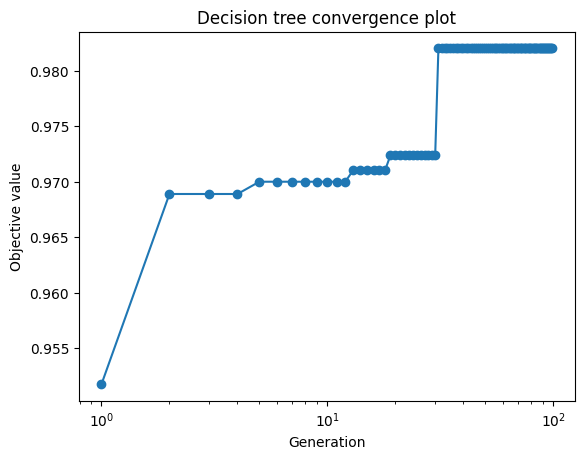

In [34]:
lb=[1,0.1,0.1,0,0.1,1,2,0]
ub=[10,0.9,0.9,0.49,1,50,50,10]
dictionary=differential_evolution_real_encoding(decision_tree,100,lb,ub,"max")
best_var=dictionary.popitem()
#acc=modeling([15,0.5,0.5,0.25,0.5,42,5,2.5])
#print(acc)
evals=[]

for val in list(dictionary.values()):
  evals.append(decision_tree(val))

convergence_graph(evals,"Decision tree")

In [35]:
print(decision_tree(best_var[1]))

0.9819996480378108


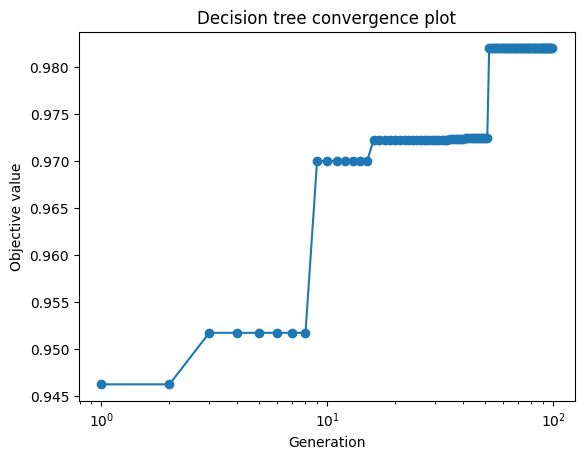

0.9819996480378108


In [37]:
lb=[1,0.1,0.1,0,0.1,1,2,0]
ub=[10,0.9,0.9,0.49,1,50,50,10]
dictionary=differential_evolution_real_encoding(decision_tree,100,lb,ub,"max")
best_var=dictionary.popitem()
#acc=modeling([15,0.5,0.5,0.25,0.5,42,5,2.5])
#print(acc)
evals=[]

for val in list(dictionary.values()):
  evals.append(decision_tree(val))

convergence_graph(evals,"Decision tree")
print(decision_tree(best_var[1]))

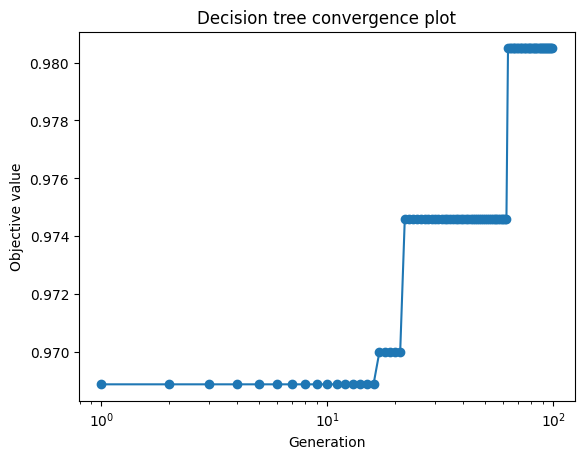

0.9804912386555045


In [40]:
lb=[1,0.1,0.1,0,0.1,1,2,0]
ub=[10,0.9,0.9,0.49,1,50,50,10]
dictionary=differential_evolution_real_encoding(decision_tree,100,lb,ub,"max")
best_var=dictionary.popitem()
#acc=modeling([15,0.5,0.5,0.25,0.5,42,5,2.5])
#print(acc)
evals=[]

for val in list(dictionary.values()):
  evals.append(decision_tree(val))

convergence_graph(evals,"Decision tree")
print(decision_tree(best_var[1]))

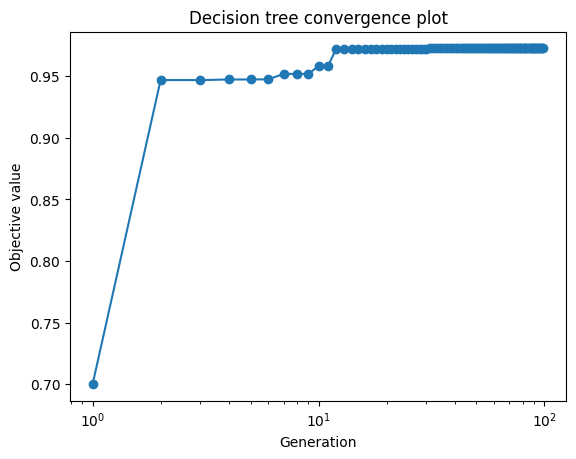

0.972471528772909


In [43]:
lb=[1,0.1,0.1,0,0.1,1,2,0]
ub=[10,0.9,0.9,0.49,1,50,50,10]
dictionary=differential_evolution_real_encoding(decision_tree,100,lb,ub,"max")
best_var=dictionary.popitem()
#acc=modeling([15,0.5,0.5,0.25,0.5,42,5,2.5])
#print(acc)
evals=[]

for val in list(dictionary.values()):
  evals.append(decision_tree(val))

convergence_graph(evals,"Decision tree")
print(decision_tree(best_var[1]))